# Behavioral Cloning

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
%matplotlib inline


# 1. Data wrangling

## 1.1 Read log file

In [6]:
# file directory
file_path = "./driving_log.csv"

In [7]:
# read csv file
drive_log = pd.read_csv(file_path)
print(drive_log.shape)

(8036, 7)


## 1.2 Get steering angle (Y)

count    8036.000000
mean        0.004070
std         0.128840
min        -0.942695
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering, dtype: float64


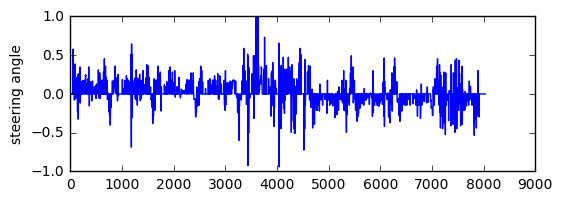

In [8]:
# select the steering angle
Y = drive_log['steering']

# peek the data
print(Y.describe())

# convert pandas to ndarray
Y = np.asarray(Y)

# plot steering angle
plt.figure(figsize=(6, 2))

plt.plot(Y)
plt.ylabel('steering angle')

## 1.3 Get image directory

In [9]:
# image directory
img_dir = drive_log['center']

# peek the directory
img_dir.head()

0    IMG/center_2016_12_01_13_30_48_287.jpg
1    IMG/center_2016_12_01_13_30_48_404.jpg
2    IMG/center_2016_12_01_13_31_12_937.jpg
3    IMG/center_2016_12_01_13_31_13_037.jpg
4    IMG/center_2016_12_01_13_31_13_177.jpg
Name: center, dtype: object

## 1.4 Get image data

In [10]:
# load a image file given an image directory
def load_img(img_dir):
    img = mpimg.imread(img_dir)
    return img

(160, 320, 3)
<class 'numpy.ndarray'>


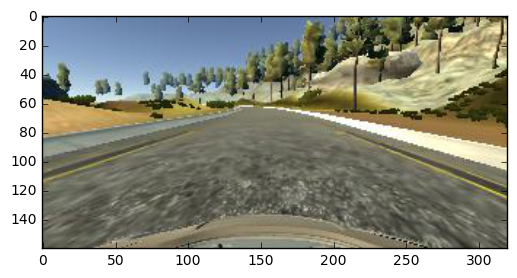

In [11]:
# Test the function
img1 = load_img(img_dir[5000])

plt.imshow(img1) # plot image
print(img1.shape)
print(type(img1))

# 1.5 Preprocess image (select region, resize, normalize)

In [12]:
global img_x 
global img_y
img_x = 80 
img_y = 20

In [14]:
def process_img(img):
    
    # select area of interst
    img = img[60:140, 0:320]
    
    # reduce size
    img = cv2.resize(img, (img_x, img_y))
    
    # normailize
    img  = img.astype('float32') # convert int to float
    img = img/255 - 0.5
    
    return img

(20, 80, 3)


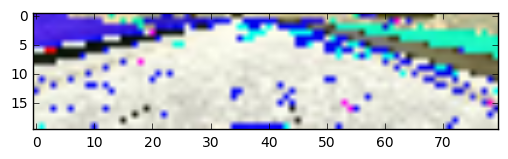

In [15]:
# Test the function
img2 = process_img(img1)
print(img2.shape)
plt.imshow(img2)


# 1.6 Stack all images (X)

### Initialize

In [16]:
# inicialize X
n_img = len(img_dir)
X = np.empty((n_img,img_y,img_x,3))

print(X.shape)

(8036, 20, 80, 3)


In [17]:
# stack the image to make X
def stack_img(img_dir): # input directory, and image
    n_img = len(img_dir)
    for n in range(n_img):
        img = load_img(img_dir[n]) # load color image
        img = process_img(img) # grey and small
        X[n,:,:,:]=img
    return X

In [19]:
# process the data log
X = stack_img(img_dir)

In [ ]:
# size of the data
print('X shape:',X.shape)
print('data size:',X.nbytes)


In [ ]:
# Test if the funciton is corect
img = X[9000,:,:,:]

print('Image size:', img.shape)
plt.imshow(img)# show image

# Save X and Y

In [24]:
#Binary data
#np.save('X.npy', X)
#np.save('Y.npy', Y)

# 2. CNN model 

In [ ]:
# load library
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop


In [ ]:
# input shape
input_shape = X.shape[1:]
print('Input shape:',input_shape)

In [ ]:
from sklearn.cross_validation import train_test_split

X, X_test, Y, y_test = train_test_split(X,Y,test_size=0.2)

print('Train size:', X.shape)
print('Test size:', X_test.shape)


## 2.1 define CNN

In [27]:
# Initiating the model
stride=(2,2)
stride2=(1,1)

model = Sequential()

model.add(Convolution2D(24,3,3,subsample=stride,input_shape = input_shape, name='cn1'))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Convolution2D(12, 3, 3,subsample=stride,name='cn2'))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Convolution2D(8, 3, 3,subsample=stride2,name='cn3'))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Convolution2D(4, 2, 2,subsample=stride2,name='cn4'))
model.add(Dropout(0.3))
model.add(Activation('relu'))


model.add(Flatten(name='flatten'))

model.add(Dense(20, name='fc1'))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(20, name='fc2'))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(20, name='fc3'))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(20, name='fc4'))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(1, name='fc5'))


# Print out summary of the model
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cn1 (Convolution2D)              (None, 9, 39, 24)     672         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
dropout_17 (Dropout)             (None, 9, 39, 24)     0           cn1[0][0]                        
____________________________________________________________________________________________________
activation_17 (Activation)       (None, 9, 39, 24)     0           dropout_17[0][0]                 
____________________________________________________________________________________________________
cn2 (Convolution2D)              (None, 4, 19, 12)     2604        activation_17[0][0]              
___________________________________________________________________________________________

## 2.2 Train model

### large learning rate

In [28]:
# Compile model using Adam optimizer 
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr = 0.001))

In [29]:
# change learning rate
model.fit(X, Y, 
           batch_size = 256, nb_epoch= 30, 
           verbose=1, callbacks=[], validation_split=0.3,shuffle=True)

Train on 16122 samples, validate on 6910 samples
Epoch 1/30
16122/16122 [==============================] - 15s - loss: 0.0998 - val_loss: 0.0936
Epoch 2/30
16122/16122 [==============================] - 14s - loss: 0.0997 - val_loss: 0.0938
Epoch 3/30
16122/16122 [==============================] - 13s - loss: 0.0967 - val_loss: 0.0761
Epoch 4/30
16122/16122 [==============================] - 14s - loss: 0.0842 - val_loss: 0.0703
Epoch 5/30
16122/16122 [==============================] - 14s - loss: 0.0788 - val_loss: 0.0696
Epoch 6/30
16122/16122 [==============================] - 13s - loss: 0.0753 - val_loss: 0.0671
Epoch 7/30
16122/16122 [==============================] - 12s - loss: 0.0738 - val_loss: 0.0665
Epoch 8/30
16122/16122 [==============================] - 12s - loss: 0.0728 - val_loss: 0.0640
Epoch 9/30
16122/16122 [==============================] - 12s - loss: 0.0709 - val_loss: 0.0668
Epoch 10/30
16122/16122 [==============================] - 12s - loss: 0.0705 - val_los

# 2.3 Test model performance

## Test on the test set

In [20]:
# test 
test_scores = model.evaluate(X_test, y_test, verbose=0)

print('Test score:', test_scores)

# test results 
pred_test = model.predict(
                    x = X_test,
                    batch_size=1,
                    verbose=1)

# plot test set
plt.figure(1)  
plt.figure(figsize=(6, 2))
plt.title('prediction')
plt.plot(pred_test)
plt.plot(np.asarray(y_test))


NameError: name 'model' is not defined

## Test on the traing set

# 2.3 Save weights and model

In [31]:
# load library
import json
import h5py

In [36]:
# Save model as json file
json_string = model.to_json()

# save weights
with open('model.json', 'w') as outfile:
        json.dump(json_string, outfile)

        # save weights
        model.save_weights('./model.h5')
        print("Model saved")

Model saved


### Reload cnn model

In [33]:
from keras.models import model_from_json
with open("model.json", 'r') as jfile:
    model = model_from_json(json.load(jfile))
#model.compile("adam", "mse")
model.load_weights("model.h5")

### Fine learning rate

In [34]:
# Compile model using Adam optimizer 
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr = 0.00001))

In [35]:
# change learning rate
model.fit(X, Y, 
           batch_size = 256, nb_epoch= 20, 
           verbose=1, callbacks=[], validation_split=0.3,shuffle=True)

Train on 16122 samples, validate on 6910 samples
Epoch 1/20
16122/16122 [==============================] - 15s - loss: 0.0634 - val_loss: 0.0633
Epoch 2/20
16122/16122 [==============================] - 14s - loss: 0.0628 - val_loss: 0.0630
Epoch 3/20
16122/16122 [==============================] - 13s - loss: 0.0629 - val_loss: 0.0628
Epoch 4/20
16122/16122 [==============================] - 12s - loss: 0.0622 - val_loss: 0.0625
Epoch 5/20
16122/16122 [==============================] - 11s - loss: 0.0630 - val_loss: 0.0625
Epoch 6/20
16122/16122 [==============================] - 11s - loss: 0.0628 - val_loss: 0.0623
Epoch 7/20
16122/16122 [==============================] - 11s - loss: 0.0619 - val_loss: 0.0622
Epoch 8/20
16122/16122 [==============================] - 11s - loss: 0.0624 - val_loss: 0.0623
Epoch 9/20
16122/16122 [==============================] - 12s - loss: 0.0621 - val_loss: 0.0622
Epoch 10/20
16122/16122 [==============================] - 12s - loss: 0.0626 - val_los